<a href="https://colab.research.google.com/github/Arun-nexus/deep_learning/blob/main/pytorch_image_calssifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sharansmenon/animals141

Dataset URL: https://www.kaggle.com/datasets/sharansmenon/animals141
License(s): copyright-authors
  0% 0.00/60.5M [00:00<?, ?B/s]
100% 60.5M/60.5M [00:00<00:00, 764MB/s]


In [98]:
import zipfile
with zipfile.ZipFile("animals141.zip","r") as zip:
  zip.extractall("animal")

In [7]:
from torchvision import transforms


In [11]:
augmentation=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [27]:
dataset="/content/animal/dataset"
training_data = ImageFolder(root=dataset,transform=augmentation)

In [29]:
train_size=int(0.7*len(training_data))
val_size=len(training_data)-train_size

In [17]:
from torch.utils.data import random_split

In [32]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [30]:
train_data,val_data=random_split(training_data,[train_size,val_size])

In [34]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=128,num_workers=2)
val_loader=DataLoader(val_data,batch_size=128,num_workers=2)

In [22]:
from torch import nn

In [57]:
class animal_cnn(nn.Module):
  def __init__(self,num_classes=141):
    super(animal_cnn,self).__init__()
    self.feature=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32,64,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(64,128,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(128*16*16,256),
    nn.Dropout(0.25),
    nn.Linear(256,num_classes),
    )
  def forward(self,x):
    x = self.feature(x)
    return x

In [58]:
import torch

In [59]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
model=animal_cnn(num_classes=141).to(device)
model_loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=1e-4)

In [61]:
class earlystopping():
  def __init__(self,min_delta,patience=3):
    self.patience=patience
    self.min_delta=min_delta
    self.early_stop=False
    self.best_loss=float("inf")
    self.counter=0

  def __call__(self,val_loss):
    if val_loss>self.best_loss-self.min_delta:
      self.best_loss=val_loss
      self.counter=0
    else:
      self.counter+=1
      if self.counter>=self.patience:
        self.early_stop=True

In [62]:
epochs = 5
training_loss = []
accuracy = []
val_losses = []
val_accuracy = []

earlystopping_callback = earlystopping(min_delta=0.01, patience=2)

for epoch in range(epochs):
    model.train()
    running_loss = 0
    mcorrect, mtotal = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = model_loss(outputs, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        mcorrect += (preds == labels).sum().item()
        mtotal += labels.size(0)

    train_loss = running_loss / len(train_loader)
    acc = 100 * mcorrect / mtotal
    training_loss.append(train_loss)
    accuracy.append(acc)

    model.eval()
    val_running_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            v_loss = model_loss(outputs, labels)

            val_running_loss += v_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={acc:.2f}%, Train Loss={train_loss:.4f} | Val Acc={val_acc:.2f}%, Val Loss={val_loss:.4f}")

    earlystopping_callback(val_loss)
    if earlystopping_callback.early_stop:
        print("Early stopping triggered")
        break

Epoch 1: Train Acc=97.08%, Train Loss=0.4844 | Val Acc=100.00%, Val Loss=0.0000
Epoch 2: Train Acc=100.00%, Train Loss=0.0000 | Val Acc=100.00%, Val Loss=0.0000
⛔ Early stopping triggered


In [64]:
from google.colab import files
new_data=files.upload()

Saving download (1).jpg to download (1) (1).jpg


In [65]:
from PIL import Image

In [88]:
new_image=Image.open("/content/download (1).jpg")

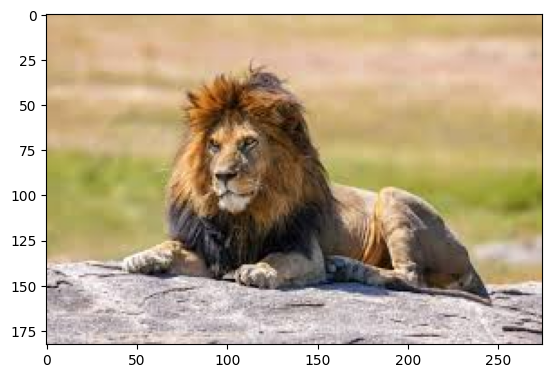

In [89]:
import matplotlib.pyplot as plt
plt.imshow(new_image)

In [92]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

new_image_tensor =(transform(new_image).unsqueeze(0)).to(device)

In [97]:
model.eval()
with torch.no_grad():
  out=model(new_image_tensor)
  idx=torch.max(out,1).indices.item()
print(training_data.classes[idx])

dataset
